## Imports

In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import regularizers
from keras import models
from datetime import datetime
from contextlib import redirect_stdout

## Dataset loader
I'm going to split data generator to train_datagen and test_datagen. I can use different data augmentations for them. Especially I don't want to modify test data in a strange way, I just want to normalize values of images to range [0, 1].

In [56]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1.0/255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(
        rescale=1.0/255)

batch_size = 32
epochs = 10

train_generator = train_datagen.flow_from_directory(
        'dataset/train',  # this is the train directory
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'dataset/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 2700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


## Model
I am giving a simple model that I create.

In [57]:
model_name = 'model1'
model_path = 'models/{}.h5'.format(model_name)

Defining callback function: early stopping and TensorBoard. I prefer using accuracy instead of loss because accuracy is a real measurement that I can interpret. Loss is only a kind of relative measurement.

In [58]:
dir_path = 'logs'
# just to be sure that directory exists
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

# TensorBoard
logdir = 'logs/{}-{}'.format(model_name, datetime.now().strftime('%Y-%m-%d'))
callbacks = list()
callbacks.append(keras.callbacks.TensorBoard(log_dir=logdir))

# EarlyStopping
callbacks.append(keras.callbacks.EarlyStopping(monitor='val_acc', mode='max'))
callbacks.append(keras.callbacks.ModelCheckpoint(model_path, monitor='val_acc',
                                                 mode='max', save_best_only=True))

Model architecture

In [59]:
input_shape = (150, 150, 3)
inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs) # 32 x 150 x 150
x = layers.MaxPool2D((2, 2))(x) # 32 x 75 x 75
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x) # 64 x 75 x 75
x = layers.MaxPool2D((2, 2))(x) # 64 x 36 x 36
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x) # 64 x 37 x 37
x = layers.MaxPool2D((2, 2))(x) # 64 x 18 x 18
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x) # 128 x 18 x 18
x = layers.MaxPool2D((2, 2))(x) # 128 x 9 x 9
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(input=inputs, output=x)

/home/lukasz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


I save model summary to distinguish models owning only their names.

In [60]:
model.summary()

dir_path = 'models'
# just to be sure that directory exists
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

with open('models/{}-summary.txt'.format(model_name), 'w') as f:
    with redirect_stdout(f):
        model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 18, 18, 64)        0         
__________

In [61]:
model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [62]:
history = model.fit_generator(train_generator,
                    steps_per_epoch= int(2700 / batch_size + 1), epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps= int(300 / batch_size + 1))

Epoch 1/10
85/85 [==============================] - 62s 732ms/step - loss: 0.6944 - acc: 0.5086 - val_loss: 0.6919 - val_acc: 0.5967
Epoch 2/10
85/85 [==============================] - 61s 712ms/step - loss: 0.6925 - acc: 0.5199 - val_loss: 0.6813 - val_acc: 0.6233
Epoch 3/10
85/85 [==============================] - 63s 736ms/step - loss: 0.6865 - acc: 0.5613 - val_loss: 0.6506 - val_acc: 0.5700
Epoch 4/10
85/85 [==============================] - 64s 758ms/step - loss: 0.6646 - acc: 0.6016 - val_loss: 0.6469 - val_acc: 0.6900
Epoch 5/10
85/85 [==============================] - 69s 811ms/step - loss: 0.6374 - acc: 0.6536 - val_loss: 0.5573 - val_acc: 0.7200
Epoch 6/10
85/85 [==============================] - 70s 819ms/step - loss: 0.6188 - acc: 0.6703 - val_loss: 0.5743 - val_acc: 0.6733
Epoch 7/10
85/85 [==============================] - 70s 819ms/step - loss: 0.6047 - acc: 0.6773 - val_loss: 0.5541 - val_acc: 0.7200
Epoch 8/10
85/85 [==============================] - 70s 826ms/step - 

In [63]:
model.save(model_path)

Model compiling and training.

## Plots

In [70]:
def plot_acc_loss(history, name):
    history_dict = history.history
    
    train_losses = history_dict['loss']
    val_losses = history_dict['val_loss']
    train_acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    
    epochs = list(range(1, len(train_losses) + 1))
    
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, '--o', label='train')
    plt.plot(epochs, val_losses, '--o', label='validation')
    plt.xlabel('num of epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.title('loss')
    
    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, '--o', label='train')
    plt.plot(epochs, val_acc, '--o', label='validation')
    plt.xlabel('num of epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('accuracy')
    
    plots_dir_path = 'plots'
    # just to be sure that directory exists
    if not os.path.exists(plots_dir_path):
        os.makedirs(plots_dir_path)
    
    plt.savefig('plots/{}.png'.format(name), bbox_inches='tight')

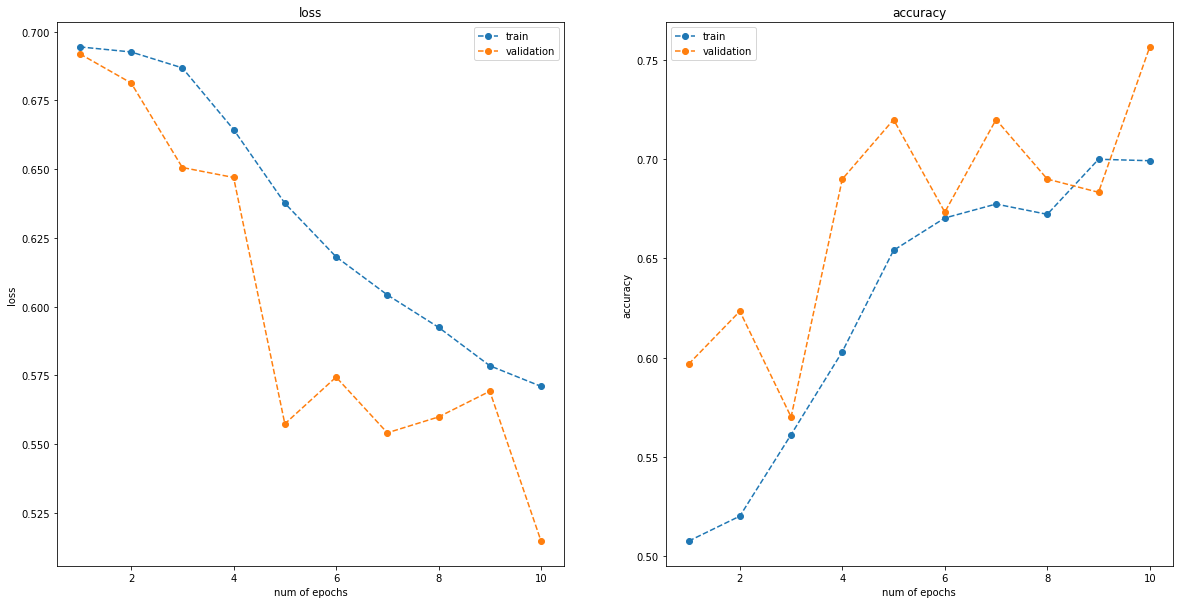

In [71]:
plot_acc_loss(history, model_name)